In [1]:
from sklearn import cross_validation, linear_model, dummy, metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold
from sklearn.preprocessing import Normalizer
from scipy import interp

import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
%matplotlib inline
import math

from redshift_query import query, remove

def describe(ara):
    me = ara.mean()
    su = ara.sum()
    le = len(ara)
    return (me, su, le)

In [4]:
qr = """
    select coalesce(a.has_membership, False) or
    coalesce(a.has_enterprise, False) or 
    coalesce(a.has_expired_enterprise, False) or
    char_length(a.membership_plan)>0 or 
    coalesce(a.total_transactional_revenue,0) > 50 as converted_in_the_end,    -- 0

    b.registration_time, 														--1
    b.domain_is_email_provider,													--2
    coalesce(b.has_membership, False) or	
    coalesce(b.has_enterprise, False) or 
    coalesce(b.has_expired_enterprise, False) or
    char_length(b.membership_plan)>0 or 
    coalesce(b.total_transactional_revenue,0) > 50 as converted,					--3 
    coalesce(b.has_linkedin, False) as has_linkedin,									--4
    b.linkedin_country,																	--5
    trim(b.company_name)='',																	--6
    coalesce(b.company_turnover,0) as turnover,	
    trim(b.user_provided_bio)='',
    trim(b.user_provided_industry)='',
    trim(b.user_provided_org)='',															--10
    b.linkedin_headline,
    b.linkedin_twitter_account,
    b.total_transactional_orders,
    b.most_popular_profile_type,
    coalesce(b.company_employees_count,0),														--15
    coalesce(b.linkedin_num_connections,-1),
    b.given_name,
    b.family_name,
    b.displayed_name,
    coalesce(b.number_of_follows,0),														   --20
    coalesce(b.total_home_page_views,0),
    coalesce(b.total_page_views,0),
    coalesce(b.total_searches,0),																--23
    coalesce(b.total_transactional_revenue, 0),
    b.next_access_after_registration,														--25
    coalesce(b.days_until_next_access_after_registration,0),
    b.company_sic_2003_code,																--27
    b.company_sic_2007_code,
    b.company_credit_rating_description,
    b.company_match_source,																	--30
    coalesce(b.total_advanced_searches,0),
    coalesce(b.total_company_searches,0),												--32
    coalesce(b.total_director_searches, 0),													--33
    coalesce(b.total_transactional_orders, 0),
    coalesce(b.total_visits, 0),															--35
    b.mail_verified,
    b.company_credit_rating,																	--37
    b.last_access_time,
    b.ds,
    coalesce(b.l7_active,0),                      --40
    coalesce(b.l28_active,0),
    coalesce(b.l84_active,0),
    coalesce(b.l182_active,0),
    a.user_id as user_id
    from latest_user_attributes a          --45
    join
    user_attributes_daily b
    on a.user_id = b.user_id
    and b.company_name <> 'DUEDIL LIMITED'
    and right(b.mail, 10) <> 'duedil.com'
    and b.registration_time > '2013-10-22'
    and (b.ds - b.registration_time::date) = 60
    and (getdate()::date - b.registration_time::date)>120
"""

In [5]:
results = query(qr)
print "total users with 60 days history %s" % len(results)
results = results[results[:,3] == False]
print "total users with 60 day who did not convert during first 14 days %s" % len(results)
print "total conversions %s" % results[:,0].sum()

total users with 60 days history 476182
total users with 60 day who did not convert during first 14 days 475716
total conversions 227


In [99]:
n = len(results[:,0])
outcomes = np.empty(n,dtype=float)
outcomes[:] = results[:,0]#map(lambda x: x=="True", results[:, 0])
# features = np.empty([n,13],dtype=float)
# features[:, 0] = np.minimum(results[:,20],15)
# features[:, 1] = np.minimum(results[:,21],15)
# features[:, 2] = np.minimum(results[:,22],15)
# features[:, 3] = np.minimum(results[:,23],15)
# features[:, 4] = results[:,2]
# features[:, 5] = results[:,4]
# features[:, 6] = results[:,24] #revenue so far
# features[:, 7] = results[:, 16]==-1    
# features[:, 9] = results[:, 6]
# features[:, 10] = results[:, 9]
# features[:, 11] = results[:, 35]==0
# features[:,8] = results[:, 35] == 1

maybefeatures = [np.minimum(results[:,20],15),
                 np.minimum(results[:,21],15),
                 np.minimum(results[:,22],15),
                 np.minimum(results[:,23],15),
                 results[:,2],
                 results[:,4],
                 results[:,24], #revenue so far
                 results[:, 16]==-1    ,
                 results[:, 6],
                 results[:, 9],
                 results[:, 35]==0,
                 results[:, 35] == 1]

def print_stats(features, outcomes):
    cv = StratifiedKFold(outcomes, n_folds=6)
    #cv = cross_validation.ShuffleSplit(n,10,0.2)
    # features = np.random.rand(2000)
    # features.resize(400, 5)
    # outcomes = np.array(map(
    #     lambda x: int(round(x)), features.dot(np.array([0.1, 0.2, 0.3, 0.4, 0.03]))))


    logistic = linear_model.LogisticRegression()
    logistic2 = linear_model.LogisticRegression()
    dum = dummy.DummyRegressor()


    predictors = [logistic, dum]
    avg_metrics = np.zeros((len(predictors), 5))

    def calc_metrics(actual, predicted):
        return np.array([
            metrics.mean_squared_error(actual, predicted),
            metrics.mean_absolute_error(actual, predicted),
            metrics.explained_variance_score(actual, predicted),
            metrics.log_loss(actual, predicted),
            metrics.roc_auc_score(actual, predicted)
        ])

    for train, test in cv:
        X_train = features[train]
        X_test = features[test]
        y_train = outcomes[train]
        y_test = outcomes[test]

        for predictor in predictors:
            predictor.fit(X_train, y_train)
        logpred = logistic.predict_proba(X_test)[:,1]
        dumpred = dum.predict(X_test)

        all_predictions = [dumpred, logpred]
        avg_metrics += np.array([calc_metrics(y_test, pre) for pre in all_predictions])/len(cv)

    avg_metrics = avg_metrics.T
    avg_metrics = [["%.4f" % x for x in y] for y in avg_metrics]

    header = ["metric\predictor"] + ["dummy", "logistic"]
    table = []
    table.append(["mse"] + avg_metrics[0])
    table.append(["mae"] + avg_metrics[1])
    table.append(["explained var"] + avg_metrics[2])
    table.append(["logloss"] + avg_metrics[3])
    table.append(["roc auc"] + avg_metrics[4])
    print tabulate(table, headers = header)
    print logistic.coef_
    
features = np.empty([n,12], dtype=float)
for j in range(12):
    features[:,j] = maybefeatures[j]
print_stats(features, outcomes)
print "\n\n"

# for j in range(12):
#     features = np.empty([n, 12], dtype=float)
#     aux = maybefeatures[0:j] + maybefeatures[j+1:12]
#     for k in range(11):
#         features[:,k] = aux[k]
#     print j
#     print_stats(features, outcomes)


metric\predictor      dummy    logistic
------------------  -------  ----------
mse                  0.0005      0.0005
mae                  0.001       0.0009
explained var       -0           0.0212
logloss              0.0041      0.0032
roc auc              0.5         0.9173
[[ 0.06047392  0.0754059   0.06512945  0.02164518 -0.79539655 -1.02145959
   0.14649882 -2.19398198 -0.82702289 -1.97444805  1.77188295 -1.34995534]]





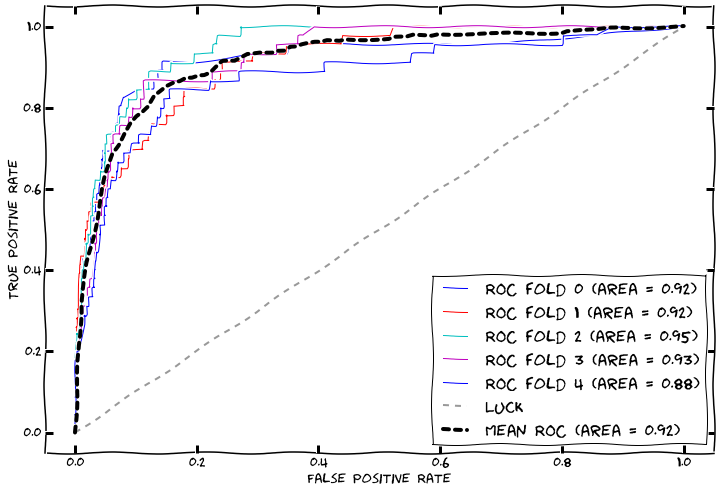

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)


In [63]:
###############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
#cv = StratifiedKFold(outcomes, n_folds=4)
plt.xkcd()
classifier = logistic
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

plt.figure(figsize=(12,8))
for i, (train, test) in enumerate(cv):
    try:
        probs = classifier.fit(features[train], outcomes[train]).predict_proba(features[test])[:,1]
    except:
        probs = classifier.fit(features[train], outcomes[train]).predict(features[test])
        # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(outcomes[test], probs)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)


plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=4, dash_capstyle = "round")

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title(str(classifier)[:100])
plt.legend(loc="lower right")
plt.show()
print str(classifier)

In [71]:
# 14 days with L7
# chamption14 = champion
# logistic14 = logistic
# 14 days
# chamption14_L7 = champion
# logistic14_L7 = logistic

In [61]:
# 30 days
# chamption30 = champion
# logistic30 = logistic
# 30 days with L7
# chamption30_L7 = champion
# logistic30_L7 = logistic

In [51]:
# 7 days with L7
# chamption7_L7 = champion
# logistic7_L7 = logistic
# 7 days without L7
# chamption7 = champion
# logistic7 = logistic

In [87]:
# 60 days
# chamption60 = champion
# logistic60 = logistic
# 60 days with L7
# chamption60_L7 = champion
# logistic60_L7 = logistic

In [652]:
print describe(outcomes[results[:,14] == '']) 
print describe(outcomes[results[:,14] == 'directors']) 
print describe(outcomes[results[:,14] == 'companies']) 
print ""
print describe(outcomes[results[:,31] == 3]) 
print describe(outcomes[results[:,31] == 4]) 
print describe(outcomes[results[:,31] == 5]) 
print describe(outcomes[results[:,31] > 5]) 

mean = 0.00285519872984  sum = 1498.0  len = 524657
mean = 0.0012817062073  sum = 200.0  len = 156042
mean = 8.77394555976e-05  sum = 21.0  len = 239345

mean = 0.00115562403698  sum = 15.0  len = 12980
mean = 0.00157404044073  sum = 13.0  len = 8259
mean = 0.0014272970562  sum = 8.0  len = 5605
mean = 0.00297354873069  sum = 67.0  len = 22532


[0, 1, 2, 5, 7, 10, 6, 21, 22, 21, 31, 27, 0, 46, 15, 54, 44]
[0, 1, 0, 0, 1, 1, 1, 2, 3, 3, 3, 8, 2, 4, 7, 7, 6]
[0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0, 1, 0, 1, 0, 1, 1, 1, 2, 1, 2, 4, 2, 3, 0, 2, 4]
[1, 19, 0, 2, 0, 0, 0, 0, 9, 4, 0, 0, 0, 0, 0, 0, 8]
[0, 3, 0, 1, 2, 4, 4, 5, 5, 2, 9, 5, 5, 6, 13, 0, 9]


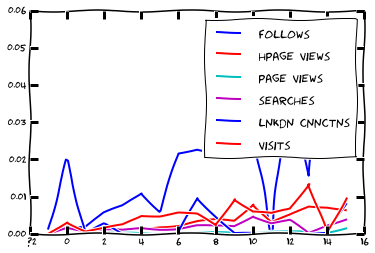

In [11]:
upper = 15
with plt.xkcd():
    for name, index in [("follows", 20), ("hpage views", 21), ("page views", 22), ("searches", 23),
                        ("lnkdn cnnctns", 16), ("visits", 35)]:
        means = []
        counts = []
        for i in range(-1,upper):
            subg = results[:, 0][results[:,index]==i]
            if len(subg)==0:
                means.append(0)
                counts.append(0)
                continue
            means.append(subg.mean())
            counts.append(len(subg))
        subg = results[:, 0][results[:,index]>=upper]
        means.append(subg.mean())
        counts.append(len(subg))
        plt.plot(range(-1,upper+1), means, label=name)
        plt.legend()
        print map(lambda x: int(1000*x), means)

In [545]:
champion.fit(features, outcomes)
pospred = champion.predict_proba(features)[:,1]>0.1

In [546]:
pospred.sum()

0

In [550]:
pospred = champion.predict_proba(features)[:,1]>0.04

In [556]:
champion.predict_proba(features)[:,1].sum()

1717.4003804803383

In [557]:
outcomes.sum()

1715.0

In [558]:
logistic.predict_proba(features)[:,1].sum()

1395.1243802926317

In [627]:
logistic.coef_

array([[  1.78264074e-01,  -1.70784449e-01,  -2.85404117e+00,
         -1.59701839e-03,  -9.28501465e-01,  -1.16434833e+00,
          1.51635513e-01,  -2.15348998e+00,   7.61652920e-01,
         -6.90869189e-01,  -1.08314116e+00,   4.07144584e-01,
          1.18690006e+00]])

In [561]:
linear.fit(features, outcomes)

LinearRegression(copy_X=True, fit_intercept=True, normalize=False)

In [564]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    features, outcomes, test_size=0.33, random_state=5)

In [565]:
for p in predictors:
    p.fit(X_train, y_train)
    try:
        probs = p.predict_proba(X_test)[:,1]
    except:
        probs = p.predict(X_test)
    print probs.sum()
    
print ""
print y_test.sum()


563.714946293
561.98770047
562.732575446
566.534083457
564.245898807

574.0


In [567]:
Exception: [[ 0.08059038  0.          0.05395241  0.04765116  0.          1.93336747
   0.08465733 -2.32670447 -1.49520507 -2.32670447  2.44061837 -0.94214166]]
 len = 541730 

set([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0])
set([0.0])  total_home_page_views  fixed?
set([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0])
set([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0])
set([0.0])  domain_is_email_provider  fixed?
set([0.0, 1.0])
set([0.0, 16.000000000000004, 11.583333333333332, 4.0, 9.7916666666666679, 15.590000000000003, 10.783333333333333, 59.199999999999918, 14.790000000000004, 13.991666666666669, 31.57, 22.375000000000004, 39.960000000000001, 12.391666666666669, 19.981666666666669, 20.000000000000007, 16.390000000000004, 20.190000000000008, 7.3899999999999997, 34.983333333333334, 18.983333333333338, 13.991666666666667, 24.000000000000011, 18.591666666666676, 9.7899999999999991, 17.19166666666667, 4.9899999999999993, 29.960000000000001, 84.958333333333343, 15.783333333333333, 14.791666666666671, 10.790000000000001, 4.9916666666666663, 34.591666666666676, 17.380000000000003, 15.390000000000004, 22.400000000000009, 26.38333333333334, 7.1999999999999993, 8.1916666666666664, 12.991666666666671, 10.591666666666669, 29.975000000000001, 19.975000000000001, 27.349999999999994, 0.80000000000000004, 10.4, 17.383333333333336, 13.979999999999997, 70.399999999999878, 19.783333333333335, 30.75, 6.3999999999999995, 16.800000000000004, 11.58, 29.775000000000006, 20.783333333333335, 27.983333333333341, 22.591666666666679, 13.191666666666666, 20.800000000000008, 26.591666666666679, 30.790000000000003, 34.791666666666664, 29.990000000000002, 13.190000000000001, 20.583333333333336, 15.591666666666667, 24.800000000000011, 8.1899999999999995, 83.999999999999829, 14.791666666666668, 15.390000000000006, 7.3899999999999988, 11.389999999999999, 3.2000000000000002, 39.958333333333336, 22.380000000000003, 10.591666666666665, 20.38333333333334, 19.98, 17.379999999999999, 13.190000000000003, 14.590000000000003, 8.7999999999999989, 9.9799999999999986, 44.391666666666644, 27.200000000000014, 6.5916666666666668, 19.200000000000006, 23.975000000000001, 39.966666666666669, 18.183333333333334, 21.583333333333336, 18.975000000000001, 49.991666666666667, 13.99, 16.391666666666669, 12.800000000000002, 19.959999999999997, 9.5999999999999996, 14.591666666666672, 11.591666666666669, 13.791666666666671, 1.6000000000000001, 16.391666666666673, 21.600000000000009, 46.966666666666661, 12.000000000000002, 24.390000000000008, 35.741666666666667, 75.199999999999861, 25.600000000000012, 18.18, 20.766666666666666, 23.183333333333337, 5.7899999999999991, 6.589999999999999, 24.39166666666668, 15.779999999999999, 11.590000000000002, 16.391666666666666, 23.183333333333334, 13.990000000000004, 16.579999999999998, 7.3916666666666657, 19.983333333333334, 53.191666666666613, 59.999999999999915, 34.950000000000003, 24.958333333333332, 11.391666666666666, 17.990000000000006, 9.9833333333333325, 7.3916666666666666, 13.19166666666667, 14.400000000000004, 18.400000000000006, 27.359999999999999, 15.783333333333335, 13.991666666666671, 39.539999999999985, 30.791666666666668, 16.991666666666667, 19.591666666666669, 15.200000000000005, 24.583333333333339, 26.575000000000003, 10.791666666666668, 17.600000000000005, 17.989999999999998, 14.969999999999999, 26.400000000000013, 24.975000000000001, 9.9900000000000002, 10.59, 54.983333333333334, 9.7900000000000009, 14.98, 30.980000000000004, 14.974999999999998, 12.191666666666666, 29.991666666666667, 93.769999999999968, 12.391666666666667, 6.5916666666666659, 4.7999999999999998, 25.580000000000005, 15.591666666666672, 25.19166666666667, 29.966666666666669, 16.580000000000002, 44.566666666666663, 2.4000000000000004, 8.9916666666666671, 17.383333333333333, 11.200000000000001, 5.5999999999999996, 11.579999999999998, 21.991666666666671, 11.391666666666667, 13.600000000000003, 15.780000000000001, 31.183333333333344, 49.990000000000002, 29.969999999999999, 19.591666666666676, 23.783333333333339, 23.20000000000001, 32.391666666666666, 15.590000000000002, 10.783333333333331, 11.591666666666667, 33.19166666666667, 9.9916666666666671, 16.583333333333336, 31.539999999999992, 38.75, 17.991666666666667, 32.175000000000004, 13.191666666666668, 18.180000000000003, 17.191666666666674, 11.391666666666669, 10.779999999999998, 31.200000000000017, 6.5899999999999999, 14.983333333333334, 18.983333333333334, 18.175000000000001, 32.375, 22.383333333333336, 12.390000000000001, 15.59, 59.983333333333334, 11.59, 16.991666666666674, 44.991666666666667, 16.583333333333332, 36.583333333333336, 36.799999999999997, 7.9999999999999991, 5.7916666666666661, 13.791666666666664])
set([1.0])  linkedin_num_connections
set([0.0, 1.0])
set([1.0])  user_provided_industry  fixed?
set([0.0, 1.0])
set([0.0, 1.0])


metric\predictor      dummy    logistic
------------------  -------  ----------
mse                  0.0005      0.0005
mae                  0.0009      0.0009
explained var        0.0000      0.0035
roc auc              0.5000      0.8614

0
8
14


In [651]:
Exception: [[ 0.05657683  0.13501659  0.02308347 -0.00844066  0.          1.63937624
   0.09046326 -1.52693294 -3.46136925  1.9815814  -0.84317339]]
 len = 541730 

set([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0])
set([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0])
set([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0])
set([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0])
set([0.0]) domain
set([0.0, 1.0])
set([0.0, 16.000000000000004, 30.790000000000003, 4.0, 30.75, 14.590000000000003, 11.200000000000001, 59.199999999999918, 14.790000000000004, 13.991666666666669, 9.9799999999999986, 31.57, 12.000000000000002, 23.783333333333339, 19.981666666666669, 20.000000000000007, 16.390000000000004, 20.190000000000008, 7.3899999999999997, 34.983333333333334, 18.983333333333338, 9.7916666666666679, 24.000000000000011, 20.38333333333334, 9.7899999999999991, 25.19166666666667, 14.98, 29.960000000000001, 10.783333333333333, 13.791666666666671, 10.591666666666665, 20.766666666666666, 9.9833333333333325, 34.591666666666676, 12.390000000000001, 15.390000000000004, 24.975000000000001, 25.580000000000005, 7.1999999999999993, 29.966666666666669, 11.58, 17.379999999999999, 23.183333333333337, 14.591666666666672, 8.7999999999999989, 29.975000000000001, 16.391666666666669, 0.80000000000000004, 10.4, 17.383333333333336, 16.391666666666673, 24.958333333333332, 70.399999999999878, 16.800000000000004, 13.19166666666667, 93.769999999999968, 13.979999999999997, 19.783333333333335, 27.983333333333341, 22.591666666666679, 26.38333333333334, 14.400000000000004, 26.591666666666679, 19.591666666666669, 34.791666666666664, 17.990000000000006, 13.190000000000001, 14.974999999999998, 39.958333333333336, 20.583333333333336, 15.591666666666667, 24.800000000000011, 8.1899999999999995, 10.791666666666668, 15.390000000000006, 7.3899999999999988, 6.5899999999999999, 3.2000000000000002, 5.7916666666666661, 22.380000000000003, 27.349999999999994, 9.9900000000000002, 17.380000000000003, 13.190000000000003, 6.5916666666666659, 6.3999999999999995, 16.583333333333336, 44.391666666666644, 4.7999999999999998, 29.991666666666667, 23.20000000000001, 12.391666666666667, 39.966666666666669, 18.183333333333334, 18.975000000000001, 49.991666666666667, 13.99, 29.990000000000002, 12.800000000000002, 19.959999999999997, 39.539999999999985, 11.591666666666669, 1.6000000000000001, 13.191666666666666, 21.600000000000009, 13.991666666666671, 24.390000000000008, 35.741666666666667, 12.191666666666666, 25.600000000000012, 84.958333333333343, 17.191666666666674, 15.783333333333333, 4.9916666666666663, 19.975000000000001, 5.7899999999999991, 6.589999999999999, 24.39166666666668, 15.779999999999999, 24.583333333333339, 16.391666666666666, 17.991666666666667, 23.183333333333334, 19.98, 16.579999999999998, 7.3916666666666657, 8.9916666666666671, 53.191666666666613, 59.999999999999915, 34.950000000000003, 11.391666666666666, 22.375000000000004, 14.983333333333334, 7.3916666666666666, 22.383333333333336, 20.800000000000008, 18.400000000000006, 15.783333333333335, 12.991666666666671, 49.990000000000002, 54.983333333333334, 16.991666666666667, 15.200000000000005, 26.575000000000003, 14.791666666666668, 17.600000000000005, 17.989999999999998, 14.969999999999999, 26.400000000000013, 23.975000000000001, 39.960000000000001, 11.59, 10.59, 44.566666666666663, 9.7900000000000009, 4.9899999999999993, 30.980000000000004, 32.375, 8.1916666666666664, 6.5916666666666668, 21.991666666666671, 36.583333333333336, 13.990000000000004, 15.590000000000002, 9.5999999999999996, 10.790000000000001, 18.18, 15.591666666666672, 13.991666666666667, 16.580000000000002, 59.983333333333334, 2.4000000000000004, 19.983333333333334, 17.383333333333333, 22.400000000000009, 5.5999999999999996, 11.579999999999998, 20.783333333333335, 15.590000000000003, 33.19166666666667, 19.200000000000006, 15.780000000000001, 31.183333333333344, 29.969999999999999, 46.966666666666661, 19.591666666666676, 12.391666666666669, 32.391666666666666, 10.783333333333331, 11.591666666666667, 9.9916666666666671, 10.591666666666669, 21.583333333333336, 31.539999999999992, 38.75, 27.200000000000014, 32.175000000000004, 13.191666666666668, 18.180000000000003, 75.199999999999861, 11.391666666666669, 10.779999999999998, 31.200000000000017, 27.359999999999999, 11.391666666666667, 18.591666666666676, 18.983333333333334, 18.175000000000001, 7.9999999999999991, 13.791666666666664, 11.389999999999999, 15.59, 29.775000000000006, 11.590000000000002, 16.991666666666674, 17.19166666666667, 44.991666666666667, 13.600000000000003, 16.583333333333332, 30.791666666666668, 36.799999999999997, 83.999999999999829, 11.583333333333332, 14.791666666666671])
set([0.0, 1.0])
set([1.0])
set([0.0, 1.0])
set([0.0, 1.0])


metric\predictor      dummy    logistic
------------------  -------  ----------
mse                  0.0005      0.0004
mae                  0.0009      0.0009
explained var        0.0000      0.0058
roc auc              0.5000      0.8664

{'', 'companies', 'directors'}

In [2]:
Exception: [[ 0.06873897  0.12422084  0.02388618 -0.00781072 -0.59140965  1.79940918
   0.09061351 -1.20498341 -3.44520572  1.96431592 -0.90339739]]
 len = 541730 

set([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0])
set([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0])
set([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0])
set([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0])
set([0.0, 1.0])
set([0.0, 1.0])
set([0.0, 16.000000000000004, 4.0, 84.958333333333343, 14.590000000000003, 10.783333333333333, 59.199999999999918, 14.790000000000004, 13.991666666666669, 31.57, 24.583333333333339, 13.19166666666667, 39.960000000000001, 11.391666666666666, 19.981666666666669, 20.000000000000007, 16.390000000000004, 20.190000000000008, 44.391666666666644, 16.583333333333332, 29.966666666666669, 18.983333333333338, 24.000000000000011, 20.38333333333334, 9.7899999999999991, 25.19166666666667, 14.98, 29.960000000000001, 15.783333333333333, 14.791666666666671, 16.580000000000002, 9.9833333333333325, 34.591666666666676, 17.380000000000003, 15.390000000000004, 22.400000000000009, 6.589999999999999, 24.975000000000001, 25.580000000000005, 7.1999999999999993, 8.1916666666666664, 15.783333333333335, 11.58, 12.991666666666671, 23.183333333333337, 11.591666666666667, 3.2000000000000002, 8.7999999999999989, 16.391666666666673, 0.80000000000000004, 10.4, 13.191666666666668, 39.539999999999985, 24.958333333333332, 70.399999999999878, 6.3999999999999995, 16.800000000000004, 18.591666666666676, 18.400000000000006, 19.783333333333335, 23.975000000000001, 22.591666666666679, 22.383333333333336, 14.400000000000004, 26.591666666666679, 31.539999999999992, 34.791666666666664, 29.990000000000002, 36.583333333333336, 20.583333333333336, 15.591666666666667, 24.800000000000011, 8.1899999999999995, 83.999999999999829, 9.7916666666666679, 7.3899999999999988, 5.7916666666666661, 13.190000000000001, 10.591666666666665, 22.380000000000003, 26.38333333333334, 9.9900000000000002, 17.379999999999999, 13.190000000000003, 49.991666666666667, 9.9799999999999986, 2.4000000000000004, 6.5916666666666659, 19.200000000000006, 12.391666666666667, 39.966666666666669, 18.183333333333334, 21.583333333333336, 18.975000000000001, 44.991666666666667, 13.99, 16.391666666666669, 17.600000000000005, 19.959999999999997, 9.5999999999999996, 15.591666666666672, 11.591666666666669, 13.791666666666671, 1.6000000000000001, 13.191666666666666, 7.3899999999999997, 13.991666666666671, 12.000000000000002, 24.390000000000008, 35.741666666666667, 25.600000000000012, 11.59, 17.191666666666674, 20.766666666666666, 19.975000000000001, 5.7899999999999991, 6.5899999999999999, 24.39166666666668, 16.991666666666674, 18.180000000000003, 16.391666666666666, 13.990000000000004, 16.579999999999998, 7.3916666666666657, 9.9916666666666671, 53.191666666666613, 59.999999999999915, 34.950000000000003, 17.990000000000006, 22.375000000000004, 4.9916666666666663, 7.3916666666666666, 17.383333333333336, 20.800000000000008, 12.800000000000002, 10.779999999999998, 27.349999999999994, 29.775000000000006, 27.983333333333341, 49.990000000000002, 54.983333333333334, 30.791666666666668, 17.991666666666667, 15.200000000000005, 16.583333333333336, 17.989999999999998, 14.969999999999999, 26.400000000000013, 29.975000000000001, 19.98, 10.59, 34.983333333333334, 9.7900000000000009, 13.979999999999997, 4.9899999999999993, 30.980000000000004, 14.974999999999998, 12.191666666666666, 6.5916666666666668, 93.769999999999968, 11.391666666666667, 15.590000000000002, 4.7999999999999998, 10.790000000000001, 31.183333333333344, 18.18, 14.591666666666672, 15.59, 8.9916666666666671, 17.383333333333333, 29.991666666666667, 26.575000000000003, 19.983333333333334, 19.591666666666669, 5.5999999999999996, 11.200000000000001, 11.579999999999998, 21.991666666666671, 20.783333333333335, 13.600000000000003, 15.780000000000001, 21.600000000000009, 29.969999999999999, 46.966666666666661, 14.791666666666668, 19.591666666666676, 12.391666666666669, 23.20000000000001, 32.391666666666666, 11.590000000000002, 10.783333333333331, 23.183333333333334, 33.19166666666667, 13.991666666666667, 10.591666666666669, 30.75, 30.790000000000003, 38.75, 27.200000000000014, 32.175000000000004, 12.390000000000001, 75.199999999999861, 44.566666666666663, 11.391666666666669, 15.779999999999999, 31.200000000000017, 27.359999999999999, 14.983333333333334, 18.983333333333334, 18.175000000000001, 32.375, 13.791666666666664, 11.389999999999999, 16.991666666666667, 59.983333333333334, 15.590000000000003, 23.783333333333339, 17.19166666666667, 15.390000000000006, 39.958333333333336, 36.799999999999997, 7.9999999999999991, 11.583333333333332, 10.791666666666668])
set([0.0, 1.0])
set([1.0])
set([0.0, 1.0])
set([0.0, 1.0])


metric\predictor      dummy    logistic
------------------  -------  ----------
mse                  0.0005      0.0004
mae                  0.0009      0.0009
explained var        0.0000      0.0046
roc auc              0.5000      0.8680

ARBITRARY HEALTH CHECK: roc auc > 0.75 = True

1.4.0


In [100]:
moje = [ 0.05965258,  0.07176535  ,0.05974527  ,0.0267685,  -0.77503215, -0.99814366,
   0.14702373, -2.20406748, -0.85364146, -1.89941389,  1.7640456  ,-1.40651484]
moje = [ 0.06047392,  0.0754059,   0.06512945,  0.02164518 ,-0.79539655, -1.02145959,
   0.14649882, -2.19398198, -0.82702289 ,-1.97444805,  1.77188295 ,-1.34995534]

snapa = [ 0.06873897 , 0.12422084,  0.02388618 ,-0.00781072, -0.59140965,  1.79940918,
   0.09061351 ,-1.20498341 ,-3.44520572  ,1.96431592, -0.90339739]


print "\n".join(map(str,zip(moje, snapa)))

(0.06047392, 0.06873897)
(0.0754059, 0.12422084)
(0.06512945, 0.02388618)
(0.02164518, -0.00781072)
(-0.79539655, -0.59140965)
(-1.02145959, 1.79940918)
(0.14649882, 0.09061351)
(-2.19398198, -1.20498341)
(-0.82702289, -3.44520572)
(-1.97444805, 1.96431592)
(1.77188295, -0.90339739)


In [101]:
a = {}

In [102]:
a.copy()

{}

In [2]:
qr = """
    select *
    from
    user_attributes_daily
    limit 10
"""

In [3]:
results = query(qr)

In [4]:
results

array([[datetime.date(2010, 6, 19), 509, 'kirsty.mccormick@ocs.co.uk', ...,
        None, None, 'free'],
       [datetime.date(2010, 6, 20), 509, 'kirsty.mccormick@ocs.co.uk', ...,
        None, None, 'free'],
       [datetime.date(2010, 6, 21), 509, 'kirsty.mccormick@ocs.co.uk', ...,
        None, None, 'free'],
       ..., 
       [datetime.date(2010, 6, 26), 509, 'kirsty.mccormick@ocs.co.uk', ...,
        None, None, 'free'],
       [datetime.date(2010, 6, 27), 509, 'kirsty.mccormick@ocs.co.uk', ...,
        None, None, 'free'],
       [datetime.date(2010, 6, 28), 509, 'kirsty.mccormick@ocs.co.uk', ...,
        None, None, 'free']], dtype=object)